In [1]:
import sys

import numpy as np
import pandas as pd
from scipy.sparse.csgraph import connected_components
import torch
from torch_geometric.utils import degree, to_undirected
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [2]:
def compute_commute_times(adj, P=0., to_return=('avg_commute_time',)):

    adj = to_undirected(adj.type(torch.int64))
    degrees = degree(adj[0], num_nodes=adj.max()+1)
    A = torch.zeros((degrees.size(0), degrees.size(0)))
    A[adj[0], adj[1]] = 1.
    assert connected_components(A, directed=False, return_labels=False) == 1

    L = torch.diag(degrees) - A
    L_pinv = torch.linalg.pinv(L)
    L_pinv_diag = torch.diag(L_pinv)
    
    beta = torch.sum(degrees / (1 - P**degrees))
    C = beta * (L_pinv_diag.unsqueeze(0) + L_pinv_diag.unsqueeze(1) - 2*L_pinv)
    C_flattened = torch.triu(C+1., diagonal=1).flatten()
    C_filtered = C_flattened[C_flattened > 0.] - 1.
    C_mean = torch.mean(C_filtered).item()

    if not to_return:
        return C_mean
    
    out = dict()
    if 'L' in to_return:
        out['L'] = L
    if 'C' in to_return:
        out['C'] = C
    if 'C_filtered' in to_return:
        out['C_filtered'] = C_filtered
    if 'C_mean' in to_return:
        out['C_mean'] = C_mean

    return out

In [3]:
adj = torch.Tensor([
    [0, 1],
    [1, 2]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[ 0.0000,  6.6667, 13.3333],
# [ 6.6667,  0.0000,  6.6667],
# [13.3333,  6.6667,  0.0000]]

adj = torch.Tensor([
    [0, 1, 2],
    [1, 2, 0]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[0.0000, 5.3333, 5.3333],
# [5.3333, 0.0000, 5.3333],
# [5.3333, 5.3333, 0.0000]]

adj = torch.Tensor([
    [0, 0, 0, 1, 1, 2],
    [1, 2, 3, 2, 3, 3]
])
print(compute_commute_times(adj, P=0.5, to_return=('C',)))
# [[0.0000, 6.8571, 6.8571, 6.8571],
# [6.8571, 0.0000, 6.8571, 6.8571],
# [6.8571, 6.8571, 0.0000, 6.8571],
# [6.8571, 6.8571, 6.8571, 0.0000]]

{'C': tensor([[ 0.0000,  6.6667, 13.3333],
        [ 6.6667,  0.0000,  6.6667],
        [13.3333,  6.6667,  0.0000]])}
{'C': tensor([[0.0000, 5.3333, 5.3333],
        [5.3333, 0.0000, 5.3333],
        [5.3333, 5.3333, 0.0000]])}
{'C': tensor([[0.0000, 6.8571, 6.8571, 6.8571],
        [6.8571, 0.0000, 6.8571, 6.8571],
        [6.8571, 6.8571, 0.0000, 6.8571],
        [6.8571, 6.8571, 6.8571, 0.0000]])}


In [2]:
dataset = TUDataset(root='./data', name='Proteins')
len(dataset)

1113

In [5]:
molecule = dataset[0]
result = compute_commute_times(molecule.edge_index, P=0., to_return=('commute_times_filtered', 'avg_commute_times'))

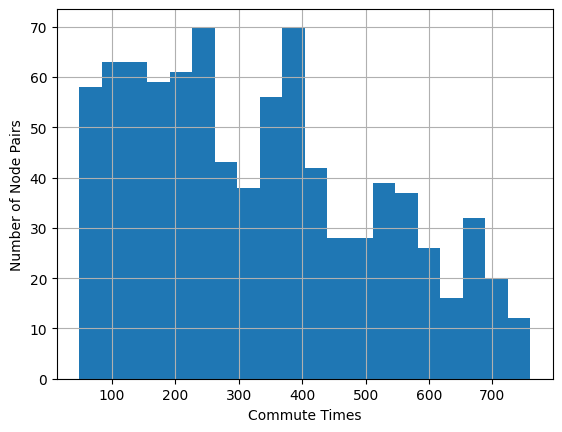

In [6]:
plt.hist(result['commute_times_filtered'], bins=20)
plt.xlabel('Commute Times')
plt.ylabel('Number of Node Pairs')
plt.grid()
plt.show()

In [5]:
avg_commute_times = list()

for i in range(len(dataset)):
    molecule = dataset[i]
    try:
        result = compute_commute_times(molecule.edge_index)
        avg_commute_times.append(result['avg_commute_time'])
    except:
        print(f"{sys.exc_info()[0].__name__}, i = {str(i).rjust(4, ' ')}, " +
            f"num connected components = {sp.csgraph.connected_components(to_scipy_sparse_matrix(molecule.edge_index, num_nodes=molecule.num_nodes), directed=False, return_labels=False)}, " +
            f'num isolated nodes = {molecule.num_nodes - degree(molecule.edge_index[0], num_nodes=molecule.num_nodes).count_nonzero()}, ' + 
            f'num nodes = {molecule.num_nodes}'
        )

_LinAlgError, i =  404, num connected components = 2, num isolated nodes = 1, num nodes = 123
_LinAlgError, i =  645, num connected components = 4, num isolated nodes = 1, num nodes = 56
_LinAlgError, i =  702, num connected components = 2, num isolated nodes = 1, num nodes = 94
_LinAlgError, i =  758, num connected components = 9, num isolated nodes = 0, num nodes = 140
_LinAlgError, i =  790, num connected components = 2, num isolated nodes = 0, num nodes = 65
_LinAlgError, i =  989, num connected components = 2, num isolated nodes = 1, num nodes = 20
_LinAlgError, i =  993, num connected components = 2, num isolated nodes = 1, num nodes = 60
_LinAlgError, i = 1008, num connected components = 4, num isolated nodes = 0, num nodes = 57


In [9]:
i = 1095
molecule = dataset[i]
print(
    f"i = {str(i).rjust(4, ' ')}, " +
    f"num connected components = {sp.csgraph.connected_components(to_scipy_sparse_matrix(molecule.edge_index, num_nodes=molecule.num_nodes), directed=False, return_labels=True)}, " +
    f'num isolated nodes = {molecule.num_nodes - degree(molecule.edge_index[0], num_nodes=molecule.num_nodes).count_nonzero()}, ' + 
    f'num nodes = {molecule.num_nodes}'
)

i = 1095, num connected components = (2, array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])), num isolated nodes = 0, num nodes = 12


In [19]:
i = 1095
molecule = dataset[i]
print(
    f"i = {str(i).rjust(4, ' ')}, " +
    f"num connected components = {sp.csgraph.connected_components(to_scipy_sparse_matrix(molecule.edge_index, num_nodes=molecule.num_nodes), directed=False, return_labels=True)}, " +
    f'num isolated nodes = {molecule.num_nodes - degree(molecule.edge_index[0], num_nodes=molecule.num_nodes).count_nonzero()}, ' + 
    f'num nodes = {molecule.num_nodes}'
)

print(*molecule.edge_index[:, torch.isin(molecule.edge_index[0], torch.Tensor([0,2,3,4,5,6]))].numpy().tolist(), sep='\n')
print(*molecule.edge_index[:, ~torch.isin(molecule.edge_index[0], torch.Tensor([0,2,3,4,5,6]))].numpy().tolist(), sep='\n')

[0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6]
[2, 5, 6, 0, 4, 5, 6, 4, 5, 6, 2, 3, 5, 6, 0, 2, 3, 4, 6, 0, 2, 3, 4, 5]
[1, 1, 1, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11]
[7, 10, 11, 1, 9, 10, 11, 9, 10, 11, 7, 8, 10, 11, 1, 7, 8, 9, 11, 1, 7, 8, 9, 10]


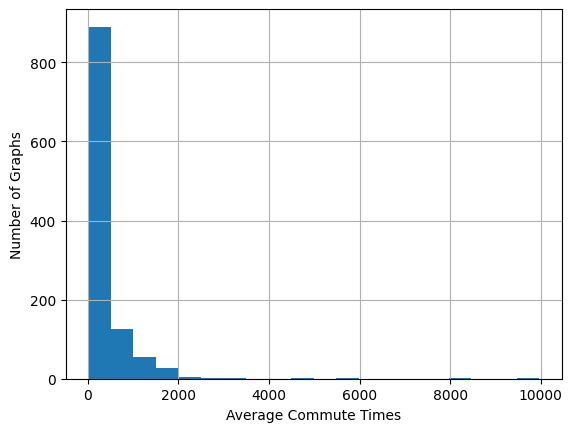

In [73]:
plt.hist(avg_commute_times, bins=20)
plt.xlabel('Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()

In [11]:
DROP_P = 0.5

delta_avg_commute_times = list()

for i in range(len(dataset)):
    molecule = dataset[i]
    if connected_components(to_scipy_sparse_matrix(molecule.edge_index, num_nodes=molecule.num_nodes), directed=False, return_labels=False) > 1:
        continue
    no_drop = compute_commute_times(molecule.edge_index, P=0., to_return=('commute_times', 'commute_times_filtered'))
    drop = compute_commute_times(molecule.edge_index, P=DROP_P, to_return=('commute_times', 'commute_times_filtered'))
    assert torch.all(drop.get('commute_times') >= no_drop.get('commute_times'))
    diff = drop.get('commute_times_filtered') - no_drop.get('commute_times_filtered')
    print(diff.min().item()/molecule.num_edges, diff.max().item()/molecule.num_edges, diff.mean().item()/molecule.num_edges)
    # delta_avg_commute_times.append((drop-no_drop)/no_drop)

delta_avg_commute_times = np.array(delta_avg_commute_times)

0.024854212631413967 0.3886153609664352 0.16982125647274066
0.04281184984290082 0.9309745456861414 0.3831892428190812
0.041794047636144305 0.27271270751953125 0.14925378911635456
0.02619196021038553 0.1767830226732337 0.09252069307410199
0.027644656953357515 0.14593215215773808 0.07914502280099052
0.0337476085513512 0.7181904748665481 0.25937136721356485
0.03902074062463009 0.5611498283617424 0.24861711444276752
0.04009497793097245 0.3007027475457442 0.15798370461714895
0.05895805358886719 0.8844695091247559 0.3742048442363739
0.02583046329831614 0.2700654557607706 0.11252278263129077
0.03546514009174548 0.4774430927477385 0.20548805437589945
0.02680026783662684 0.3333065257352941 0.1553877550012925
0.030466874440511067 0.5440101623535156 0.2385359075334337
0.043360268891747315 1.5638810342817164 0.5977693244592467
0.03662583886123285 0.5709690000952744 0.2353236966016816
0.0596742090189232 3.9221675081073113 1.0524308546534125
0.06857333605802512 0.7940712457970728 0.42316436767578125

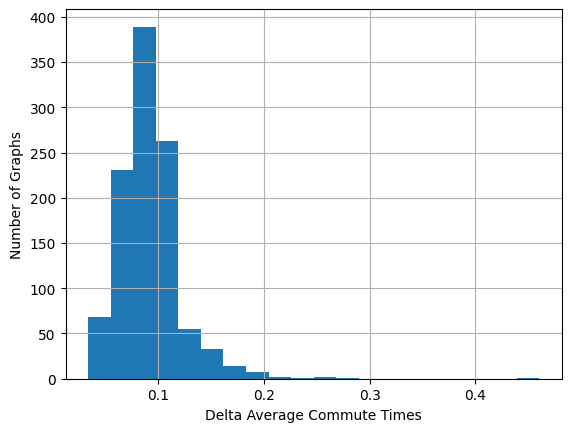

In [11]:
plt.hist(delta_avg_commute_times, bins=20)
plt.xlabel('Delta Average Commute Times')
plt.ylabel('Number of Graphs')
plt.grid()
plt.show()

In [21]:
pd.DataFrame(100*delta_avg_commute_times, columns=['Avg Commute Time (% Change)']).describe()

,Avg Commute Time (% Change)
count,1067.000000
mean,9.223757
std,3.024800
min,3.383963
25%,7.407572
50%,9.089749
75%,10.401593
max,46.031754


In [14]:
k = 20

num_nodes = np.array([molecule.num_nodes for molecule in dataset])
idx_k = np.argpartition(num_nodes, k)[:k]
print(idx_k, num_nodes[idx_k], sep='\n')

[ 959 1044  450 1104 1041 1088 1046  906  751  678  949  747 1002  700
  975 1012  983 1022  890  726]
[4 4 4 4 4 4 4 4 4 5 4 4 5 4 5 5 4 5 5 5]


In [30]:
dataset[1012].edge_index

tensor([[0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4],
        [1, 2, 3, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 1, 2, 3]])

In [140]:
i = np.random.choice(len(dataset))
step = 0.01
Ps = np.arange(0., 1., step)

adj = dataset[i].edge_index
adj = to_undirected(adj.type(torch.int64))
assert connected_components(to_scipy_sparse_matrix(adj), directed=False, return_labels=False) == 1
degrees = degree(adj[0], num_nodes=adj.max()+1)
adj_dense = torch.zeros((degrees.size(0), degrees.size(0)))
adj_dense[adj[0], adj[1]] = 1.

stationary_dists = torch.zeros((Ps.shape[0], dataset[i].num_nodes))
L_pinv = torch.linalg.pinv(torch.diag(degrees) - adj_dense)

for j, P in enumerate(Ps):

    prob_mat = (torch.eye(degrees.size(0))-torch.diag(P**degrees)) @ torch.linalg.inv(torch.diag(degrees)) @ adj_dense \
        + torch.diag(P**degrees)
    K = torch.diag(degrees) - torch.diag(degrees) @ prob_mat
    K_pinv = torch.linalg.pinv(K)

    print(torch.allclose(K_pinv, L_pinv @ torch.linalg.inv(torch.diag(1-P**degrees))), (K_pinv - L_pinv @ torch.linalg.inv(torch.diag(1-P**degrees))).mean())

True tensor(0.)
False tensor(-8.1853e-10)
False tensor(-2.2054e-10)
False tensor(-3.8600e-10)
False tensor(-1.1078e-10)
False tensor(3.9245e-10)
False tensor(8.0061e-11)
False tensor(6.7473e-12)
False tensor(2.5207e-10)
False tensor(-4.6717e-10)
False tensor(-1.2236e-10)
False tensor(-5.6647e-10)
False tensor(1.4038e-10)
False tensor(-1.5106e-11)
False tensor(-1.2185e-11)
False tensor(-5.6324e-10)
False tensor(2.1571e-10)
False tensor(-2.8882e-10)
False tensor(-2.0141e-12)
False tensor(1.8429e-10)
False tensor(3.1823e-10)
False tensor(-3.1783e-10)
False tensor(-7.1219e-10)
False tensor(7.1783e-10)
False tensor(-9.6153e-10)
False tensor(-9.5428e-10)
False tensor(-6.1833e-10)
False tensor(-7.4441e-10)
False tensor(1.0473e-11)
False tensor(-6.1511e-10)
False tensor(-5.7241e-10)
False tensor(3.1098e-10)
False tensor(-7.5328e-11)
False tensor(-1.7080e-10)
False tensor(-1.5323e-09)
False tensor(-4.4874e-10)
False tensor(9.4341e-10)
False tensor(-3.6576e-10)
False tensor(-4.2055e-10)
False te

In [117]:
for m in range(stationary_dists.size(1)):
    q = Ps[m]
    RHS = degrees / (1-q**degrees)
    RHS = RHS / RHS.sum()
    LHS = RHS @ compute_commute_times(dataset[i].edge_index, q, to_return=('prob_mat',)).get('prob_mat')
    print(q, torch.allclose(RHS, LHS), torch.max(RHS-LHS))

0.0 True tensor(0.)
0.01 True tensor(4.6566e-10)
0.02 True tensor(9.3132e-10)
0.03 True tensor(9.3132e-10)
0.04 True tensor(1.8626e-09)
0.05 True tensor(9.3132e-10)
0.06 True tensor(9.3132e-10)
0.07 True tensor(9.3132e-10)
0.08 True tensor(9.3132e-10)
0.09 True tensor(9.3132e-10)
0.1 True tensor(9.3132e-10)
0.11 True tensor(9.3132e-10)
0.12 True tensor(4.6566e-10)
0.13 True tensor(9.3132e-10)
0.14 True tensor(9.3132e-10)
0.15 True tensor(9.3132e-10)
0.16 True tensor(4.6566e-10)
0.17 True tensor(0.)
0.18 True tensor(9.3132e-10)
0.19 True tensor(9.3132e-10)
0.2 True tensor(9.3132e-10)
0.21 True tensor(9.3132e-10)
0.22 True tensor(9.3132e-10)
0.23 True tensor(9.3132e-10)
0.24 True tensor(9.3132e-10)
0.25 True tensor(4.6566e-10)
0.26 True tensor(9.3132e-10)
0.27 True tensor(1.8626e-09)
0.28 True tensor(0.)
0.29 True tensor(9.3132e-10)
0.3 True tensor(9.3132e-10)
0.31 True tensor(9.3132e-10)
0.32 True tensor(9.3132e-10)
0.33 True tensor(4.6566e-10)
0.34 True tensor(1.8626e-09)
0.35000000000

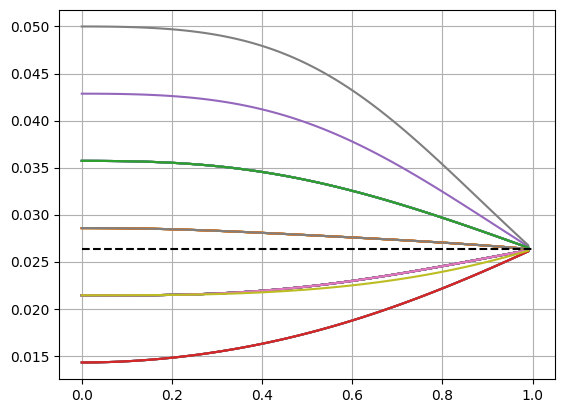

In [65]:
for m in range(stationary_dists.shape[1]):
    plt.plot(Ps, stationary_dists[:, m])

d = 3
a = d / dataset[i].edge_index.size(1)
b = 1 / dataset[i].num_nodes

y = (1-Ps**d)*a + (Ps**d)*b
plt.plot(Ps, y)

plt.hlines([1/dataset[i].num_nodes], xmin=0., xmax=1., linestyles='dashed', color='black')

plt.grid()
plt.show()

In [57]:
torch.unique(degree(dataset[i].edge_index[0]), return_inverse=True)

(tensor([2., 3., 4., 5., 6., 7.]),
 tensor([0, 3, 2, 1, 1, 0, 1, 2, 2, 0, 3, 2, 1, 2, 4, 1, 3, 3, 1, 3, 1, 2, 3, 0,
         3, 1, 1, 5, 1, 1, 1, 2, 3, 0, 1, 1, 1, 2]))

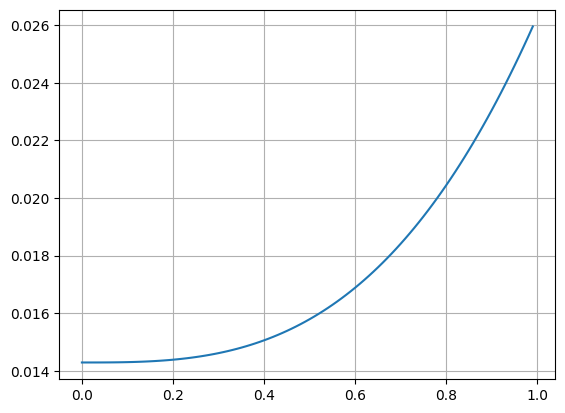

In [61]:
a = 2 / dataset[i].edge_index.size(1)
b = 1 / dataset[i].num_nodes
d = 3

y = (1-Ps**d)*a + (Ps**d)*b
plt.plot(Ps, y)
plt.grid()
plt.show()

In [94]:
# A = torch.Tensor([
#     [0, 1, 0],
#     [1, 0, 1],
#     [0, 1, 0]
# ])
A = torch.round(torch.rand(10, 10)); A = A * A.transpose(0, 1)
degrees = A.sum(dim=1, keepdim=True)
P = A / degrees
L = torch.eye(A.size(0)) - P

torch.allclose(degrees.T @ L, torch.zeros(A.size(0))), degrees.T @ L, torch.zeros(A.size(0))

(False,
 tensor([[ 0.0000e+00,  0.0000e+00, -1.1921e-07,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))